In [140]:
import pandas as pd
import numpy as np
from google.colab import drive

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os
import yfinance as yf

In [141]:
drive.mount('/content/drive')
df_call = pd.read_csv('/content/drive/My Drive/CapstoneProject/IVSurfaceWay/Data/2025-08-19spx_call_options.csv')
df_put = pd.read_csv('/content/drive/My Drive/CapstoneProject/IVSurfaceWay/Data/2025-08-19spx_put_options.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [291]:
PATH = '/content/drive/My Drive/CapstoneProject/IVSurfaceWay/Result'
DATE = '2025-08-19'

# Data Cleaning

In [142]:
def get_current_spot_price(date):
  spx = yf.Ticker("^SPX")
  hist = spx.history(start=date) # Get data for July 15, 2024

  spot_price = float(hist['Close'].iloc[0])
  return spot_price

SPOT = get_current_spot_price(DATE)

In [143]:
def clean_df(df, DATE=DATE):
  temp_df = df.copy()
  temp_df["expirationDate"]= pd.to_datetime(temp_df["expirationDate"])
  date = pd.to_datetime(DATE)
  temp_df['T'] = (temp_df["expirationDate"]-date).dt.days
  temp_df.rename(columns = {"strike":"K", "lastPrice":'price', 'impliedVolatility':'IV'}, inplace = True)
  temp_df = temp_df[(temp_df['openInterest'] >= 1) | (temp_df['volume'] >= 1)]
  temp_df = temp_df[(temp_df['K'] <= SPOT*1.25) & (temp_df['K'] >= SPOT*0.75)]
  temp_df = temp_df[temp_df['T'] <= 200]
  temp_df = temp_df[temp_df['IV'] > 0.001]
  return temp_df


In [144]:
cleaned_call = clean_df(df_call)
cleaned_put = clean_df(df_put)

In [145]:
cleaned_call.head(1)

,contractSymbol,lastTradeDate,K,price,bid,ask,change,percentChange,volume,openInterest,IV,inTheMoney,contractSize,currency,expirationDate,T
0,SPXW250819C05000000,2025-08-19 15:03:11+00:00,5000.0,1425.9,1402.3,1420.5,152.34998,11.962623,1.0,1.0,1.375003,True,REGULAR,USD,2025-08-19,0


In [146]:
cleaned_put.head(1)

,contractSymbol,lastTradeDate,K,price,bid,ask,change,percentChange,volume,openInterest,IV,inTheMoney,contractSize,currency,expirationDate,T
12,SPXW250819P05000000,2025-08-14 19:30:15+00:00,5000.0,0.05,0.0,0.05,0.0,0.0,47.0,936.0,1.359378,False,REGULAR,USD,2025-08-19,0


In [304]:
# graph_raw
def graph_raw(datadf, Z='IV', fst_axis=None, second_axis=None,
              title='3D Scatter Plot of Option Prices', spot=SPOT,
              path=None, date=None, DATE=DATE):
  # datadf["expirationDate"]= pd.to_datetime(datadf["expirationDate"])
  # date = pd.to_datetime(DATE)
  # datadf['T'] = (datadf["expirationDate"]-date).dt.days
  # datadf['K'] = datadf['strike']

  X_vals = datadf['K']
  Y_vals = datadf['T']
  Z_vals = datadf[Z]

  fig = plt.figure(figsize=(14, 10))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_vals, Y_vals, Z_vals, c=Z_vals, cmap='viridis')

  ax.set_xlabel('Strike')
  ax.set_ylabel('Days to Expiration')
  ax.set_zlabel('IV')
  ax.set_title(f'{title} of {date} with spot:{round(spot, 2)}')
  fig.colorbar(ax.scatter(X_vals, Y_vals, Z_vals, c=Z_vals, cmap='viridis'),
               ax=ax, shrink=0.5, label=Z)
  ax.view_init(fst_axis, second_axis)

  if path is not None:
    plt.savefig(path + f'/{date}BlendedIVScatter.png')
  else:
    plt.show()

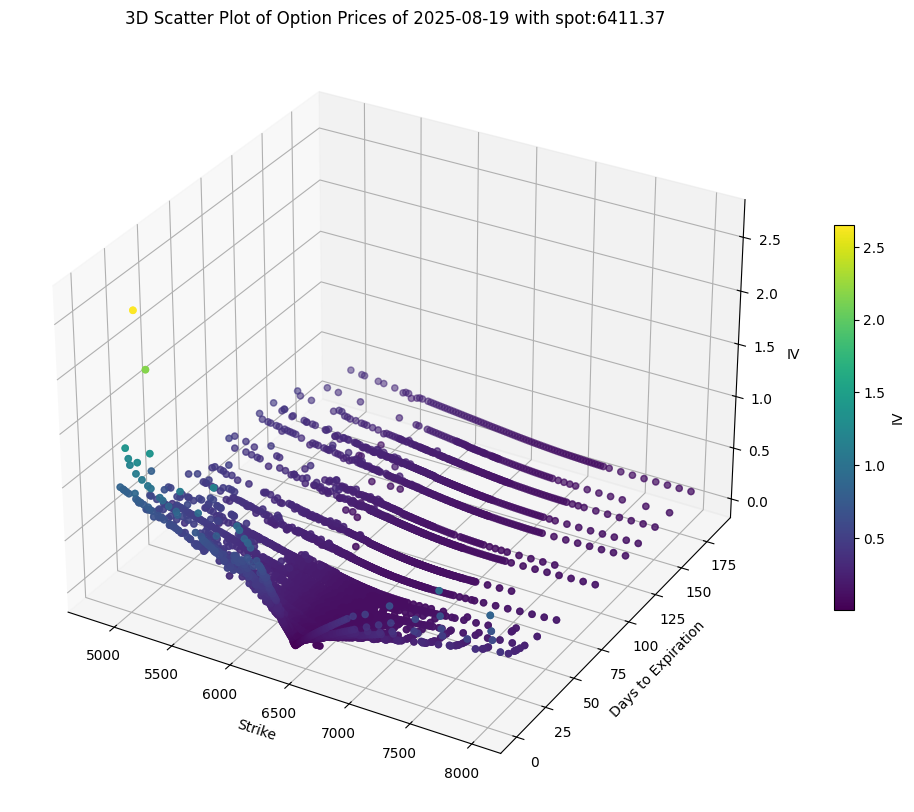

In [300]:
graph_raw(cleaned_call)

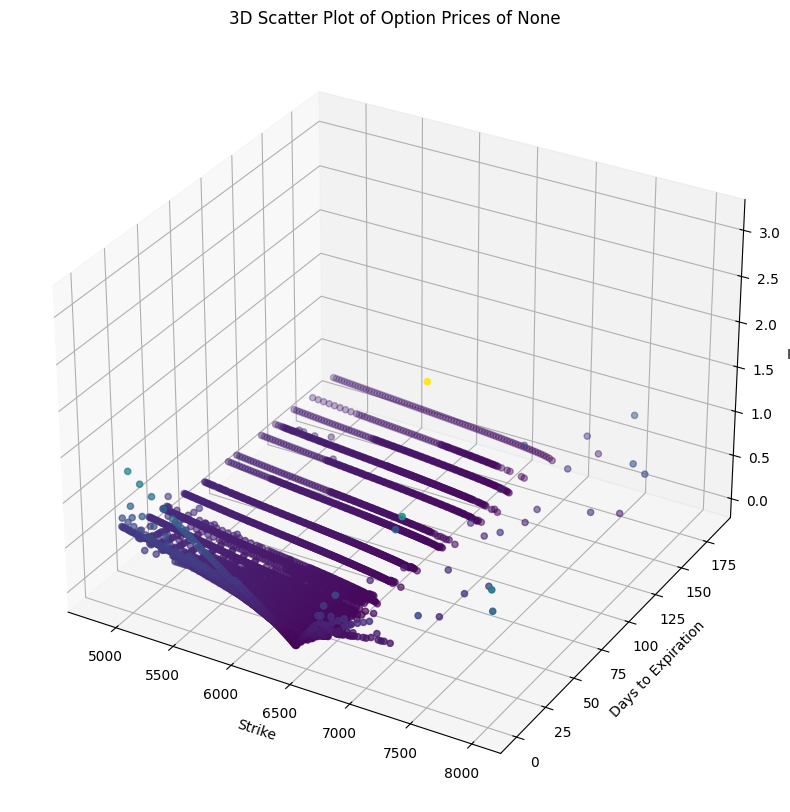

In [149]:
graph_raw(cleaned_put)

# IV blending

In [293]:
def blend_data(cleaned_calls, cleaned_puts, spot=SPOT, path=None, date=None):
    df_call = cleaned_calls[['K', 'T', 'IV', 'openInterest']].copy()
    df_put = cleaned_puts[['K', 'T', 'IV', 'openInterest']].copy()

    # Far-from-spot slices
    sliced_call = df_call[df_call['K'] >= spot * 1.02]
    sliced_put = df_put[df_put['K'] <= spot * 0.98]

    # Near-the-money slices (±2%)
    small_sliced_call = df_call[(df_call['K'] <= spot * 1.02) & (df_call['K'] >= spot * 0.98)]
    small_sliced_put = df_put[(df_put['K'] <= spot * 1.02) & (df_put['K'] >= spot * 0.98)]

    # Merge near-the-money calls and puts on strike & maturity
    merged_df = pd.merge(
        small_sliced_call, small_sliced_put,
        on=['K', 'T'], suffixes=('_call', '_put')
    )

    # Weighted IV
    merged_df['IV'] = (
        merged_df['IV_call'] * merged_df['openInterest_call'] +
        merged_df['IV_put'] * merged_df['openInterest_put']
    ) / (merged_df['openInterest_call'] + merged_df['openInterest_put'])

    # Keep only desired columns
    merged_df = merged_df[['K', 'T', 'IV', 'openInterest_call', 'openInterest_put']]

    # Final blended dataset: far calls + merged + far puts
    final_df = pd.concat([sliced_call, merged_df, sliced_put], ignore_index=True)

    # Add call and put price to the final_df based on cleaned_call and cleaned_puts
    final_df = pd.merge(
      final_df,
      cleaned_calls[['K', 'T', 'price']].rename(columns={'price': 'call_price'}),
      on=['K', 'T'],
      how='left'
    )

    final_df = pd.merge(
      final_df,
      cleaned_puts[['K', 'T', 'price']].rename(columns={'price': 'put_price'}),
      on=['K', 'T'],
      how='left'
    )

    if path is not None:
      final_df.to_excel(path + f'/{date}BlendedIV.xlsx')

    return final_df


In [296]:
blended_df = blend_data(cleaned_call, cleaned_put, path=PATH, date=DATE)
blended_df

,K,T,IV,openInterest,openInterest_call,openInterest_put,call_price,put_price
0,6540.0,0,0.140634,2251.0,NaN,NaN,0.03,132.32
1,6545.0,0,0.145516,530.0,NaN,NaN,0.03,125.46
2,6550.0,0,0.149911,1188.0,NaN,NaN,0.03,145.80
3,6555.0,0,0.154794,719.0,NaN,NaN,0.03,118.80
4,6560.0,0,0.159676,1241.0,NaN,NaN,0.03,88.39
...,...,...,...,...,...,...,...,...
6350,6175.0,185,0.150090,2100.0,NaN,NaN,459.75,168.80
6351,6200.0,185,0.147361,2915.0,NaN,NaN,518.75,174.79
6352,6225.0,185,0.144605,2343.0,NaN,NaN,460.09,168.84
6353,6250.0,185,0.141871,1491.0,NaN,NaN,452.86,173.10


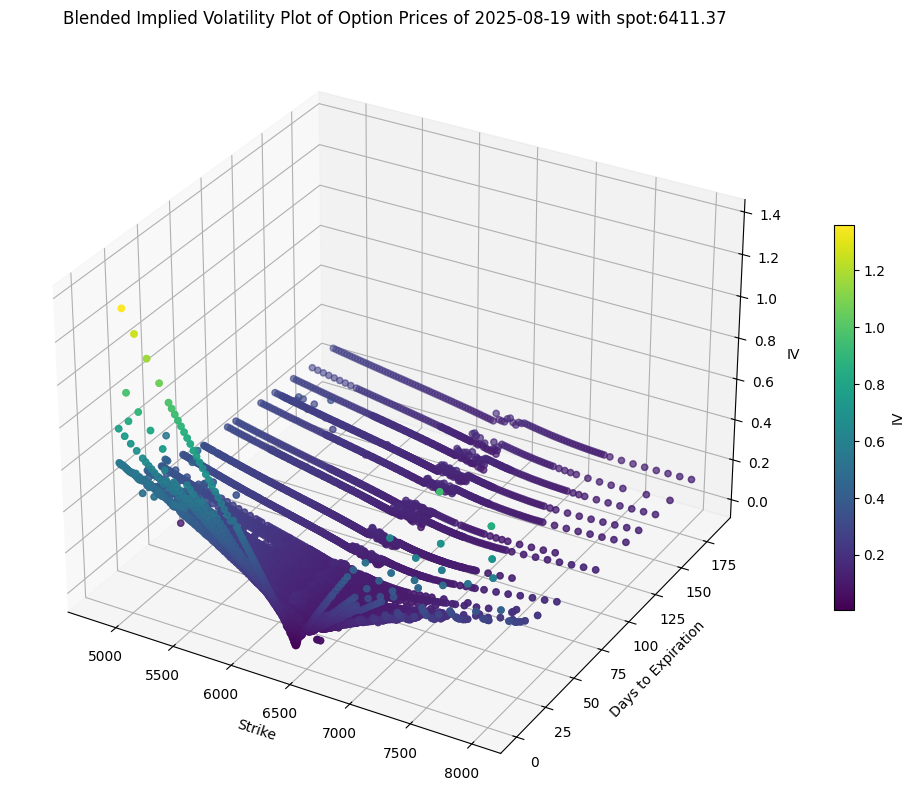

In [303]:
graph_raw(blended_df, Z='IV', fst_axis=None, second_axis=None,
              title='Blended Implied Volatility Plot of Option Prices', spot=SPOT,
              path=PATH, date=DATE)

# ML part

In [165]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

class OptionPriceDataset(Dataset):
    def __init__(self, df):
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        # Fit and transform inputs
        self.X = self.scaler_X.fit_transform(df[['K', 'T']].values)
        self.y = self.scaler_y.fit_transform(df[['IV']].values)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return x, y
    def inverse_transform_y(self, y_scaled_tensor):
        y_np = y_scaled_tensor.detach().cpu().numpy()
        return self.scaler_y.inverse_transform(y_np)

class FeedForwardRegressor(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_inputs, num_hidden),
            nn.Softplus(),
            nn.Linear(num_hidden, num_hidden),
            nn.Softplus(),
            nn.Linear(num_hidden, num_outputs)
        )
    def forward(self, x):
        return self.net(x)
    def loss(self, y_pred, y_true):
        return F.mse_loss(y_pred, y_true)
    def training_step(self, batch):
        X, y = batch
        y_hat = self(X)
        return self.loss(y_hat, y)
    def configure_optimizers(self, lr=0.01):
        return torch.optim.Adam(self.parameters(), lr)

class Trainer:
    def __init__(self, model, train_loader, device='cpu', lr=0.01):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.device = device
        self.lr = lr
        self.best_score = float('inf')
        self.best_model_state = None

    def fit(self, epochs=100):
        optimizer = self.model.configure_optimizers(self.lr)
        for epoch in range(epochs):
            self.model.train()
            for batch in self.train_loader:
                optimizer.zero_grad()
                loss = self.model.training_step(batch)
                loss.backward()
                optimizer.step()
            if loss < self.best_score:
                self.best_score = loss
                self.best_model_state = self.model.state_dict()
    def load_best_model(self):
        if self.best_model_state:
            self.model.load_state_dict(self.best_model_state)

def full_train(datadf, epochs=100, learnR=0.01):
    # Create a new model instance each time
    model = FeedForwardRegressor(num_inputs=2, num_hidden=64)

    # Prepare dataset
    train_dataset = OptionPriceDataset(datadf)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Train
    trainer = Trainer(model, train_loader, lr=learnR)
    trainer.fit(epochs)
    trainer.load_best_model()
    return model, train_loader

In [305]:
def surface_plot(datadf, model, path=None, date=None, faxis=None, saxis=None,
                 train_loader=None, spot_price=None):
  # Create
  d202501013 = datadf
  moneyness_min = d202501013['K'].min()
  moneyness_max = d202501013['K'].max()
  T_min = d202501013['T'].min()
  T_max = d202501013['T'].max()
  # Step 1: Create meshgrid and model prediction surface
  K_vals = np.linspace(moneyness_min, moneyness_max, 20)
  T_vals = np.linspace(T_min, T_max, 20)
  grid = np.array([[K, T] for T in T_vals for K in K_vals])  # shape (400, 2)

  # Normalize the input grid using the fitted scaler
  scaler_X = train_loader.dataset.scaler_X
  scaler_y = train_loader.dataset.scaler_y
  grid_scaled = scaler_X.transform(grid)

  x_tensor = torch.tensor(grid_scaled, dtype=torch.float32)

  # Model prediction (on normalized input)
  model.eval()
  with torch.no_grad():
      call_prices_scaled = model(x_tensor)

  # Inverse-transform the output price to original scale
  call_prices_np = scaler_y.inverse_transform(call_prices_scaled.cpu().numpy()).reshape(len(T_vals), len(K_vals))

  # Prepare meshgrid for plotting
  K_vals_grid, T_vals_grid = np.meshgrid(K_vals, T_vals)

  # Step 2: Prepare scatter points from original df_cleaned
  df_scatter = d202501013.copy()
  scatter_x = df_scatter['K'].values
  scatter_y = df_scatter['T'].values
  scatter_z = df_scatter['IV'].values

  # Step 3: Plot surface + scatter
  fig = plt.figure(figsize=(14, 10))
  ax = fig.add_subplot(111, projection='3d')

  # Surface (predicted)
  ax.plot_surface(K_vals_grid, T_vals_grid, call_prices_np.reshape(len(T_vals), len(K_vals)), alpha=0.7, cmap='viridis')

  # Scatter (real), colored by call price
  sc = ax.scatter(
      scatter_x, scatter_y, scatter_z,
      c=scatter_z,              # color by call price
      cmap='viridis',            # choose any colormap you like
      s=10,
      label='Implied Volatility'
  )

  fig.colorbar(sc, ax=ax, shrink=0.5, label='Implied Volatility')

  ax.set_xlabel("Strike (K)")
  ax.set_ylabel("Maturity (T)")
  ax.set_zlabel(f"Call Price")
  ax.set_title(f"Predicted Implied Volatility Surface, date:{date},spot price:{round(spot_price, 2)}")
  ax.legend()
  ax.view_init(elev=faxis, azim=saxis)
  if path is not None:
    plt.savefig(path + f'/{date}IVSurface.png')
  else:
    plt.show()

In [168]:
model, train_loader = full_train(blended_df)

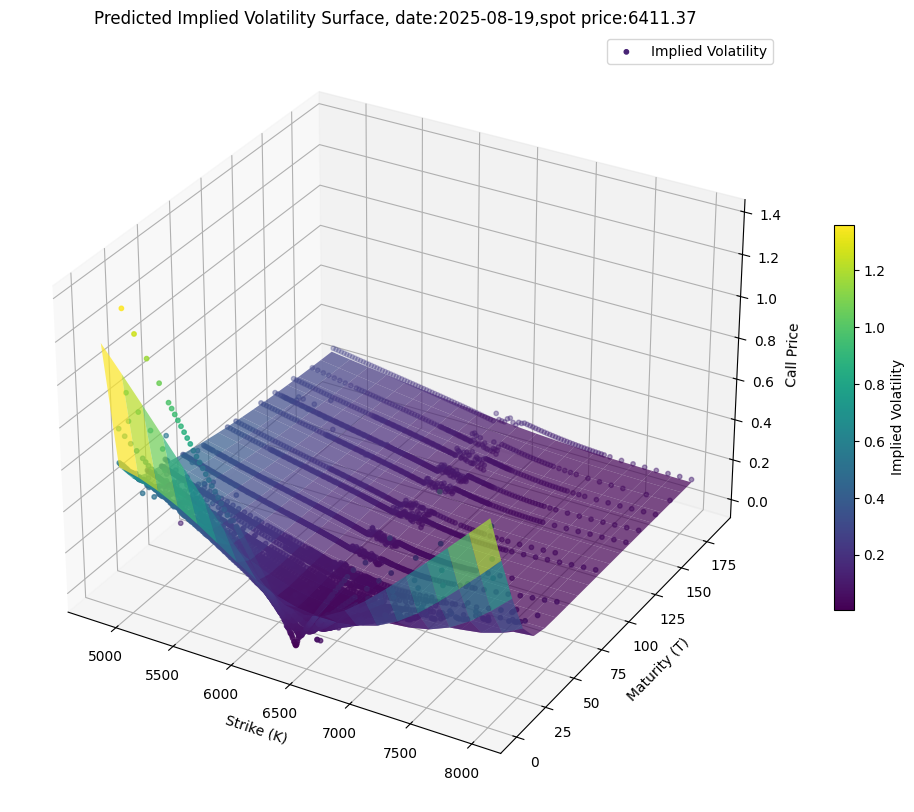

In [306]:
surface_plot(blended_df, model, path=PATH, date=DATE, faxis=None, saxis=None,
               train_loader=train_loader, spot_price=SPOT)

# Yield Curve

In [181]:
df_yield = pd.read_csv('/content/drive/My Drive/CapstoneProject/IVSurfaceWay/Data/2025-08-19yield_curve.csv')

In [179]:
import numpy as np
import pandas as pd
import re

def _col_to_years(col: str) -> float:
    """
    Convert tenor column names like '1 Mo', '1.5 Month', '2 Yr', '30 Yr' to years.
    Assumes 30 days per month, 365 days per year.
    """
    s = col.strip().replace('Months', 'Month').replace('Mos', 'Mo').replace('Yrs', 'Yr')
    m = re.match(r'^(\d+(\.\d+)?)\s*(Mo|Month|Yr|Year)$', s)
    if not m:
        raise ValueError(f"Unrecognized tenor column: {col}")
    qty = float(m.group(1))
    unit = m.group(3)
    if unit in ('Mo', 'Month'):
        return (qty * 30.0) / 365.0
    else:  # 'Yr' or 'Year'
        return qty

def rate_from_yield_curve(d, df_yield, row=0, convention='cont', clamp=True):
    """
    Map days-to-maturity -> interest rate using the given yield curve.

    Parameters
    ----------
    d : int | float | array-like
        Days to maturity.
    df_yield : pd.DataFrame
        First row (by default) contains columns like '1 Mo', '1.5 Month', '2 Mo', '6 Mo', '1 Yr', ... with % yields.
    row : int
        Which row of df_yield to use (default: 0, the most recent).
    convention : {'cont','simple'}
        Return rate as continuous-compounded ('cont') or simple annualized ('simple').
    clamp : bool
        If True, clamp outside the curve to the nearest endpoint. If False, allow linear extrapolation.

    Returns
    -------
    r : float or np.ndarray
        Annual rate in decimal (e.g., 0.043 for 4.3%).
    """
    # Pick the curve row and collect tenor columns (ignore 'Date' or non-numeric cells)
    row_series = df_yield.iloc[row]
    cols = [c for c in df_yield.columns if c != 'Date']

    # Build x (years) and y (yields as decimals)
    tenors_years = []
    yields = []
    for c in cols:
        val = row_series[c]
        if pd.isna(val):
            continue
        try:
            y = float(val) / 100.0  # convert % to decimal
            t = _col_to_years(c)
            tenors_years.append(t)
            yields.append(y)
        except Exception:
            # Skip columns that aren't tenor columns
            continue

    if not tenors_years:
        raise ValueError("No valid tenor columns found in df_yield.")

    x = np.array(tenors_years, dtype=float)
    y = np.array(yields, dtype=float)

    # Sort by maturity just in case
    order = np.argsort(x)
    x = x[order]
    y = y[order]

    # Convert input days -> years
    d_arr = np.asarray(d, dtype=float)
    t_query = d_arr / 365.0

    # Interpolate (or clamp) on APR first
    if clamp:
        tq = np.clip(t_query, x[0], x[-1])
    else:
        tq = t_query

    y_interp = np.interp(tq, x, y)

    # Return in requested compounding convention
    if convention == 'cont':
        # Convert APR to continuous rate: r_cont = ln(1 + APR)
        r = np.log1p(y_interp)
    elif convention == 'simple':
        r = y_interp
    else:
        raise ValueError("convention must be 'cont' or 'simple'")

    # Preserve scalar if input was scalar
    if np.isscalar(d):
        return float(r)
    return r

In [182]:
df_yield.head(1)

,Date,1 Mo,1.5 Month,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,08/19/2025,4.46,4.4,4.35,4.3,4.21,4.11,3.91,3.75,3.7,3.82,4.04,4.3,4.89,4.9


In [195]:
# Using your df_yield (most recent row at index 0)
r_45d = rate_from_yield_curve(90, df_yield, convention='cont')    # 45 days
r_45d

0.04210117601863539

# Recovered call price

In [196]:
# def a function that gives the predict unscaled output while input is a non scaled input
def model_prediction(model_used=None, K=6000, T=100, train_loader=None):
    model_used.eval()
    scaler_X = train_loader.dataset.scaler_X
    scaler_y = train_loader.dataset.scaler_y
    with torch.no_grad():
        x_tensor = torch.tensor([[K, T]], dtype=torch.float32)
        x_transformed = scaler_X.transform(x_tensor.numpy())
        x_tensor = torch.tensor(x_transformed, dtype=torch.float32)
        y_pred_scaled = model_used(x_tensor)
        y_pred_np = scaler_y.inverse_transform(y_pred_scaled.cpu().numpy()).reshape(1, 1)
    return y_pred_np

In [217]:
import numpy as np
from scipy.stats import norm

# def r_from_CPP(c, p, T, S, K):
#     # Returns the risk free rate used in black scholes for the current option pair
#     T = T / 365
#     # # Avoid division by zero or log of non-positive values
#     # if T <= 0 or K <= 0 or (p + S - c) / K <= 0:
#     #   return np.nan
#     r = (np.log((p+S-c)/K))/(-T)
#     return r

def black_scholes_call(S, K, T, r, sigma):
    """
    Black–Scholes European call price (no dividends).

    Parameters
    ----------
    S : float
        Spot price
    K : float
        Strike price
    T : float
        Time to maturity in DAYS
    r : float
        Annualized continuously compounded risk-free rate (e.g., 0.04 for 4%)
    sigma : float
        Annualized volatility
    """
    # Convert days -> years
    T = T / 365.0

    if T <= 0 or sigma <= 1e-9:  # handle expiry and tiny vol
        return max(S - K, 0.0)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    result = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    return result[0, 0]



In [322]:
def single_price_prediction(K=None, T=None, model_used=None, train_loader=None, yield_data=df_yield, spot_price=SPOT):
    r_t = rate_from_yield_curve(T, yield_data, convention='cont')
    IV = model_prediction(model_used=model_used, K=K, T=T, train_loader=train_loader)
    p = black_scholes_call(S=spot_price, K=K, T=T, r=r_t, sigma=IV)
    return p

def recoverd_call_price(model_used=None, delta_percent=0.01,
                    llim=-12, rlim=13, start=7, end=185, freq=7,
                    train_loader=None, spot_price=None, path=None, date=None):

    K_range = spot_price * (1 + np.arange(llim, rlim) * delta_percent)  # 25 strikes from -12% to +12%
    T_range = np.arange(start, end, freq)  # weekly: 0 to 350

    # Build grid
    results = []

    for K in K_range:
        for T in T_range:
            r_t = rate_from_yield_curve(T, df_yield, convention='cont')
            IV = model_prediction(model_used=model_used, K=K, T=T, train_loader=train_loader)
            p = black_scholes_call(S=spot_price, K=K, T=T, r=r_t, sigma=IV)
            results.append({
                'Strike': round(K, 0),
                'T_days': T,
                'p_K_T': p
            })

    # Convert to DataFrame and pivot
    df_state_price = pd.DataFrame(results)
    pivot_table = df_state_price.pivot(index='Strike', columns='T_days', values='p_K_T')
    # replace any neagtive to 0
    pivot_table[pivot_table < 0] = 0
    if path is not None:
      pivot_table.to_excel(path + f'/{date}RecovedCall.xlsx')
    return pivot_table

In [317]:
recoved_call_df = recoverd_call_price(model_used=model, delta_percent=0.015,
                    llim=-12, rlim=13, start=7, end=185, freq=7,
                    train_loader=train_loader, spot_price=SPOT, path=PATH, date=DATE)

In [318]:
#recoved_call_df.to_excel('recoved_call.xlsx')
recoved_call_df.head(3)

T_days,7,14,21,28,35,42,49,56,63,70,...,119,126,133,140,147,154,161,168,175,182
Strike,,,,,,,,,,,,,,,,,,,,,
5257.0,1158.725615,1163.506436,1168.571034,1174.125918,1180.009079,1186.058562,1192.156321,1198.190965,1204.131016,1209.980537,...,1247.145721,1252.202984,1257.247634,1262.268596,1267.273715,1272.269665,1277.262405,1282.257012,1287.257962,1292.295425
5353.0,1062.695190,1067.613710,1072.838291,1078.611164,1084.767700,1091.129692,1097.561223,1103.937093,1110.217478,1116.401708,...,1155.629956,1160.945665,1166.241739,1171.507738,1176.752067,1181.982038,1187.204065,1192.423716,1197.645816,1202.900928
5450.0,966.654438,971.699080,977.089904,983.100326,989.559616,996.270574,1003.077773,1009.840838,1016.510158,1023.078851,...,1064.684310,1070.294217,1075.875048,1081.417046,1086.929400,1092.420106,1097.896236,1103.363849,1108.828331,1114.320648


## Surface plot function for K T

In [359]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from datetime import datetime


def plot_3d_scatter(dataset, size=(14, 10), elev=None, azim=None,
                    path=None, date=None, spot=SPOT, title='Recoved Call Price',
                    x_label='Days to Expiration', y_label='Strike', z_label='Call Price',
                    file_name='RecovedCall'):
  # Ensure columns (dates) are sorted
  panel_cleaned = dataset.sort_index(axis=1)

  # Get the column and index values as 1D arrays
  X_vals_1d = panel_cleaned.columns.values
  Y_vals_1d = panel_cleaned.index.values
  Z_vals = panel_cleaned.values

  # Create 2D meshgrid for X and Y values
  X_vals, Y_vals = np.meshgrid(X_vals_1d, Y_vals_1d)

  # Reshape Z_vals to match the meshgrid shape
  z_reshaped = Z_vals.reshape(len(Y_vals_1d), len(X_vals_1d))

  # Plot
  fig = plt.figure(figsize=(14, 10))
  ax = fig.add_subplot(111, projection='3d')

  # Surface (predicted)
  ax.plot_surface(X_vals, Y_vals, z_reshaped, alpha=0.7, cmap='viridis')

   # Create X, Y, Z values for scatter plot
  X_scatter = []
  Y_scatter = []
  Z_scatter = []

  for i, strike in enumerate(panel_cleaned.index):
      for j, exp_date in enumerate(panel_cleaned.columns):
          last_price = panel_cleaned.loc[strike, exp_date]
          if pd.notna(last_price):
              X_scatter.append(exp_date)
              Y_scatter.append(strike)
              Z_scatter.append(last_price)
   # Scatter (real), colored by call price


  scatter = ax.scatter(X_scatter, Y_scatter, Z_scatter, c=Z_scatter, cmap='viridis', s=10)


  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  ax.set_zlabel(z_label)
  ax.set_title(f'{title} of {date} with spot: {round(spot, 2)}')

  fig.colorbar(scatter, ax=ax, shrink=0.5, label=z_label)


  ax.view_init(elev, azim)

  if path is not None:
    plt.savefig(path + f'/{date}{file_name}.png')
  plt.show()

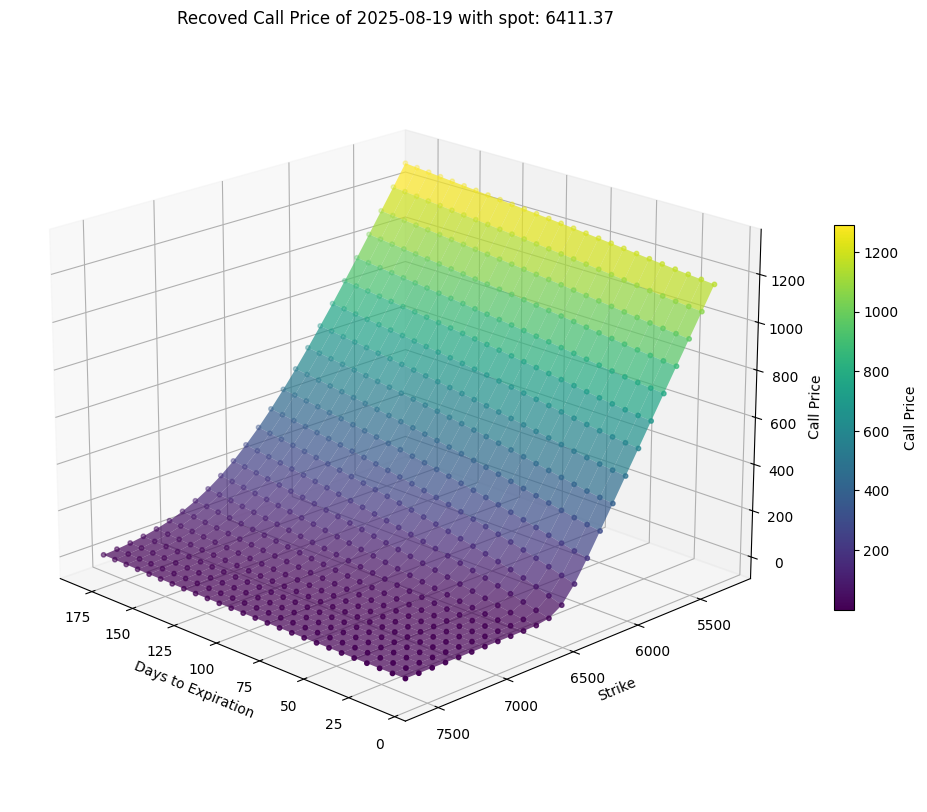

In [313]:
plot_3d_scatter(recoved_call_df, size=(14, 10), elev=20, azim=135, path=PATH, date=DATE, spot=SPOT)

# Second Order Derivative

In [337]:
# Define the seond order derivative function
def second_order_derivative(model_used=None, K=None, T=None, delta_change=0.001,
                            train_loader=None, yield_data=df_yield, spot_price=SPOT):
    delta_K = K * delta_change

    C_K_PdeltaK = single_price_prediction(K+delta_K, T, model_used=model_used, train_loader=train_loader, yield_data=yield_data, spot_price=spot_price)
    C_K_MdeltaK = single_price_prediction(K-delta_K, T, model_used=model_used, train_loader=train_loader, yield_data=yield_data, spot_price=spot_price)
    C_K_T = single_price_prediction(K, T, model_used=model_used, train_loader=train_loader, yield_data=yield_data, spot_price=spot_price)

    result = (C_K_PdeltaK - 2 * C_K_T + C_K_MdeltaK) / (delta_K ** 2)
    return result.item()

In [342]:
second_order_derivative(model_used=model, K=6500, T=7, delta_change=0.005,
                            train_loader=train_loader, yield_data=df_yield, spot_price=SPOT)

0.002934795853812485

# Raw State price

In [348]:
def raw_state_price(model_used=None, delta_percent=0.015,
                    llim=-12, rlim=13, start=7, end=185, freq=7,
                    train_loader=None, spot_price=None, path=None, date=None):

    K_range = spot_price * (1 + np.arange(llim, rlim) * delta_percent)  # 25 strikes from -12% to +12%
    T_range = np.arange(start, end, freq)  # weekly: 0 to 350

    # Build grid
    results = []

    for K in K_range:
        for T in T_range:
            p = second_order_derivative(K=K, T=T, model_used=model_used, train_loader=train_loader)
            results.append({
                'Strike': round(K, 0),
                'T_days': T,
                'p_K_T': p
            })

    # Convert to DataFrame and pivot
    df_state_price = pd.DataFrame(results)
    pivot_table = df_state_price.pivot(index='Strike', columns='T_days', values='p_K_T')
    # check negative
    if pivot_table.min().min() < 0:
      print('Negative found')

    # replace any neagtive to 0
    pivot_table[pivot_table < 0] = 0
    if path is not None:
      pivot_table.to_excel(path + f'/{date}RawStatePrice.xlsx')
    return pivot_table

In [350]:
raw_state_df = raw_state_price(model_used=model, train_loader=train_loader, spot_price=SPOT, path=PATH, date=DATE)
raw_state_df.head(3)

Negative found


T_days,7,14,21,28,35,42,49,56,63,70,...,119,126,133,140,147,154,161,168,175,182
Strike,,,,,,,,,,,,,,,,,,,,,
5257.0,0.0,0.0,0.0,0.000000e+00,0.000002,0.000006,0.000009,0.000013,0.000018,0.000022,...,0.000050,0.000054,0.000057,0.000060,0.000062,0.000065,0.000067,0.000069,0.000072,0.000073
5353.0,0.0,0.0,0.0,3.087192e-07,0.000003,0.000007,0.000012,0.000017,0.000022,0.000027,...,0.000061,0.000065,0.000069,0.000072,0.000075,0.000078,0.000081,0.000083,0.000086,0.000088
5450.0,0.0,0.0,0.0,2.095512e-06,0.000006,0.000012,0.000017,0.000023,0.000030,0.000036,...,0.000076,0.000080,0.000084,0.000088,0.000092,0.000095,0.000098,0.000100,0.000103,0.000105


# Normalized State Price

In [351]:
def build_discount_df(yield_data=df_yield, n_weeks=52):
    weeks = np.arange(1, n_weeks)
    t_years = weeks / 52
    days = weeks * 7
    r_t = rate_from_yield_curve(days, yield_data, convention='cont')
    D_t = np.exp(-r_t * t_years)

    df_discount = pd.DataFrame({
        'Week': weeks,
        'T (Years)': np.round(t_years, 6),
        'Interpolated Yield': np.round(r_t * 100, 6),
        'Discount Factor': np.round(D_t, 6),
        'Days': weeks * 7
    })

    return df_discount

In [354]:
build_discount_df().head(3)

,Week,T (Years),Interpolated Yield,Discount Factor,Days
0,1,0.019231,4.363404,0.999161,7
1,2,0.038462,4.363404,0.998323,14
2,3,0.057692,4.363404,0.997486,21


In [355]:
def state_price_matrix(df_discount=None, pivot_table=None, path=None, date=None):
  # Ensure column headers in pivot_table are integers (days)
  pivot_table.columns = pivot_table.columns.astype(int)

  # Build mapping from day to discount factor
  discount_map = dict(zip(df_discount['Days'], df_discount['Discount Factor']))

  # Normalize each column
  normalized_table = pivot_table.copy()

  for col in normalized_table.columns:
      if col in discount_map:
          col_sum = normalized_table[col].sum()
          if col_sum > 0:
              normalized_table[col] *= discount_map[col] / col_sum
  if path is not None:
      normalized_table.to_excel(path + f'/{date}(Normalized)StatePrice.xlsx')

  return normalized_table

In [357]:
NormState = state_price_matrix(df_discount=build_discount_df(), pivot_table=raw_state_df, path=PATH, date=DATE)
NormState

T_days,7,14,21,28,35,42,49,56,63,70,...,119,126,133,140,147,154,161,168,175,182
Strike,,,,,,,,,,,,,,,,,,,,,
5257.0,0.000000,0.000000,0.000000,0.000000,0.000233,0.000533,0.000889,0.001285,0.001709,0.002145,...,0.005032,0.005383,0.005713,0.006033,0.006332,0.006626,0.006898,0.007161,0.007420,0.007654
5353.0,0.000000,0.000000,0.000000,0.000030,0.000333,0.000713,0.001152,0.001635,0.002156,0.002686,...,0.006135,0.006549,0.006939,0.007305,0.007655,0.007987,0.008303,0.008596,0.008879,0.009149
5450.0,0.000000,0.000000,0.000000,0.000202,0.000623,0.001120,0.001674,0.002272,0.002902,0.003535,...,0.007594,0.008062,0.008506,0.008922,0.009318,0.009692,0.010037,0.010359,0.010666,0.010957
5546.0,0.000000,0.000000,0.000126,0.000633,0.001253,0.001933,0.002644,0.003385,0.004136,0.004890,...,0.009521,0.010056,0.010542,0.011003,0.011431,0.011827,0.012202,0.012551,0.012881,0.013184
5642.0,0.000000,0.000053,0.000648,0.001513,0.002476,0.003434,0.004372,0.005282,0.006172,0.007041,...,0.012128,0.012689,0.013213,0.013687,0.014131,0.014539,0.014924,0.015279,0.015600,0.015915
5738.0,0.000011,0.000537,0.001689,0.003202,0.004719,0.006093,0.007309,0.008410,0.009425,0.010375,...,0.015602,0.016151,0.016657,0.017124,0.017546,0.017940,0.018295,0.018625,0.018935,0.019207
5834.0,0.000319,0.001532,0.003816,0.006459,0.008818,0.010732,0.012259,0.013514,0.014579,0.015511,...,0.020211,0.020686,0.021110,0.021503,0.021856,0.022177,0.022473,0.022730,0.022971,0.023182
5931.0,0.001036,0.003898,0.008472,0.012913,0.016326,0.018751,0.020449,0.021664,0.022566,0.023266,...,0.026263,0.026552,0.026805,0.027029,0.027229,0.027406,0.027570,0.027708,0.027829,0.027927
6027.0,0.003289,0.010463,0.019204,0.025793,0.029901,0.032288,0.033591,0.034246,0.034513,0.034565,...,0.034005,0.033938,0.033886,0.033827,0.033768,0.033712,0.033648,0.033586,0.033525,0.033459


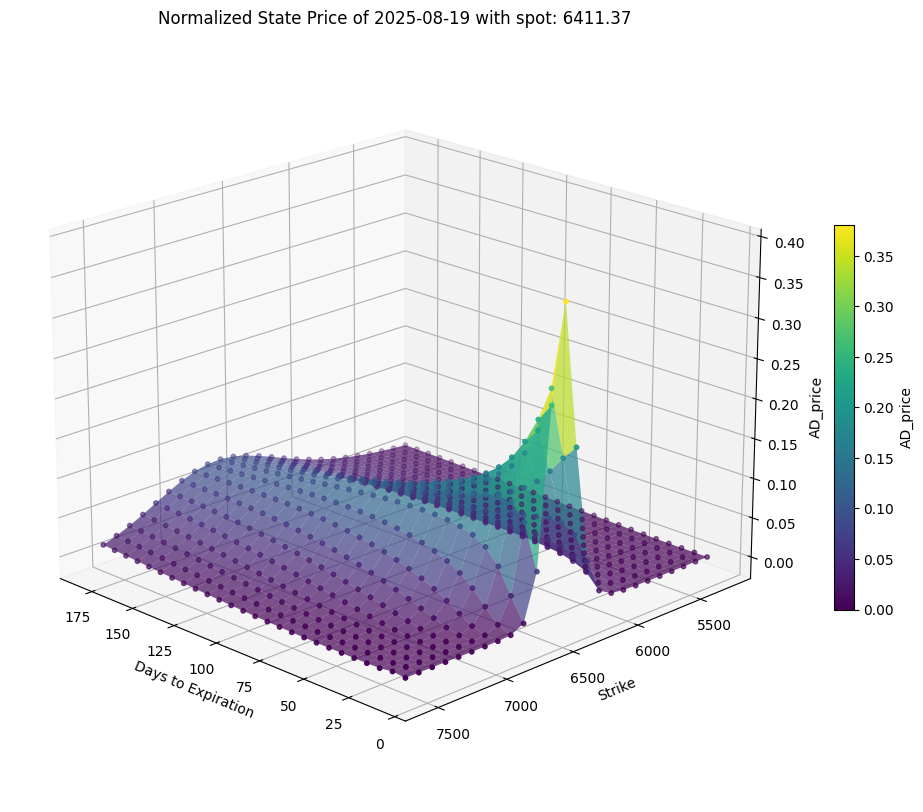

In [369]:
plot_3d_scatter(NormState, size=(14, 10), elev=20, azim=135,
                path=PATH, date=DATE, spot=SPOT, title='Normalized State Price', x_label='Days to Expiration',
                y_label='Strike', z_label='AD_price', file_name='(Normalized)StatePrice')

# State Price Transition Matrix

In [374]:
import numpy as np
import pandas as pd
from scipy.optimize import nnls, lsq_linear

def fit_state_price_transition_columnwise(Pt_matrix, ridge=0.0, scale=False):
    """
    Column-wise NNLS fit of P from p^{t+1} = p^{t} P.

    Pt_matrix: array (m, T) with columns p^t (state-price vectors).
    ridge:     nonnegative Tikhonov weight.
    scale:     True -> row-scale X for conditioning.
    """
    Pt = np.asarray(Pt_matrix, float)
    if (Pt < 0).any():
        Pt = np.maximum(Pt, 0.0)  # clip tiny negatives
    m, T = Pt.shape
    if T < 2:
        raise ValueError("Need at least two tenors (T >= 2).")

    # X shape: (T-1, m); Y shape: (T-1, m)
    X = Pt[:, :-1].T
    Y = Pt[:, 1:].T

    # Optional scaling
    if scale:
        col_scale = np.median(np.abs(X), axis=0)
        col_scale[col_scale == 0] = 1.0
        Xs = X / col_scale
    else:
        col_scale = np.ones(m)
        Xs = X

    # Optional ridge via augmentation
    if ridge > 0.0:
        R = np.sqrt(ridge) * np.eye(m)
        X_aug = np.vstack([Xs, R])
    else:
        X_aug = Xs

    P = np.zeros((m, m))
    for j in range(m):
        y = Y[:, j]
        if ridge > 0.0:
            y = np.concatenate([y, np.zeros(m)])

        coef, resnorm = nnls(X_aug, y)
        coef = coef / col_scale  # undo scaling
        P[:, j] = coef

    return P



def Transition_Matrix(spot_price, df_rename, path=None, date=None, ridge=0.000001):
    """

    """
    df_rename = df_rename.reset_index()
    df_rename['Strike'] = np.round(df_rename['Strike'] / spot_price, 2)
    df_rename = df_rename.rename(columns={'Strike': 'Moneyness'})

    maturity_cols = df_rename.columns[1:25]  # pick your tenors
    df_filtered = df_rename[['Moneyness'] + list(maturity_cols)].copy()

    # STATE PRICES per tenor, on same moneyness grid
    Pt_matrix = df_filtered.iloc[:, 1:].to_numpy(dtype=float)
    moneyness_states = df_filtered['Moneyness'].to_numpy()

    # Clean tiny negatives from numerical extraction
    Pt_matrix = np.maximum(Pt_matrix, 0.0)

    # 1) Estimate P (no row-sum=1 constraint)
    P_hat = fit_state_price_transition_columnwise(Pt_matrix, ridge=ridge, scale=False)


    P_df = pd.DataFrame(P_hat, index=moneyness_states, columns=moneyness_states)
    P_df = P_df.sort_index(axis=0).sort_index(axis=1)

    if path is not None:
        P_df.to_excel(f"{path}/{date}TransitionMatrix.xlsx")

    return P_df

In [396]:
TransState = Transition_Matrix(spot_price=SPOT, df_rename=NormState,
                                 path=PATH, date=DATE, ridge=0.000001)
TransState

,0.82,0.83,0.85,0.87,0.88,0.89,0.91,0.93,0.94,0.96,...,1.05,1.06,1.07,1.09,1.11,1.12,1.14,1.15,1.16,1.18
0.82,0.017732,0.018272,0.018731,0.020616,0.023043,0.010430,0.009049,0.006302,0.001160,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.021572,0.054604,0.070229,0.020158,0.000000,0.000000
0.83,0.020459,0.021269,0.021628,0.023406,0.026042,0.012175,0.010210,0.006885,0.001488,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.031015,0.065123,0.078452,0.013742,0.000000,0.000000
0.85,0.026877,0.029229,0.028398,0.027449,0.027059,0.013543,0.010476,0.006245,0.001754,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.045238,0.079828,0.088992,0.013244,0.000000,0.000000
0.87,0.031859,0.037543,0.038137,0.035484,0.027342,0.014730,0.011052,0.006432,0.003026,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.060496,0.097358,0.101818,0.026380,0.000000,0.000000
0.88,0.020906,0.032100,0.043463,0.049543,0.032122,0.017214,0.015971,0.013565,0.008893,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.064988,0.107050,0.102482,0.040614,0.000000,0.000000
0.89,0.000000,0.000000,0.018589,0.042644,0.044937,0.018968,0.021234,0.024720,0.023311,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.035356,0.061324,0.000000,0.000000,0.000000,0.000000
0.91,0.000000,0.000000,0.000000,0.000000,0.028912,0.019819,0.029633,0.043061,0.047399,0.027977,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.93,0.000000,0.000000,0.000000,0.000000,0.001301,0.021002,0.040597,0.069045,0.085473,0.079959,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.94,0.000000,0.000000,0.000000,0.000000,0.000000,0.022271,0.050209,0.094952,0.131189,0.142422,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.96,0.000000,0.000000,0.000000,0.000000,0.000000,0.004263,0.045470,0.098743,0.162710,0.193780,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Visualization

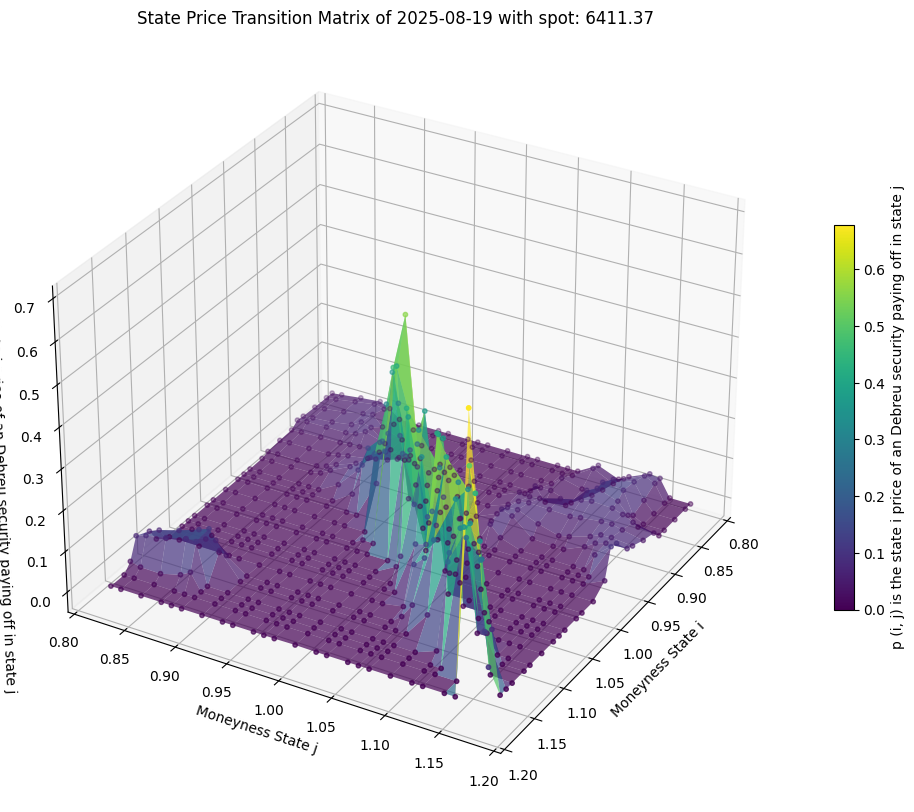

In [420]:
plot_3d_scatter(TransState, size=(14, 10), elev=30, azim=30,
                path=PATH, date=DATE, spot=SPOT, title='State Price Transition Matrix', x_label='Moneyness State i',
                y_label='Moneyness State j', z_label='p (i, j) is the state i price of an Debreu security paying off in state j', file_name='TransitionSurface')

# Natural probabiliy

In [404]:
import numpy as np
from numpy.linalg import eig
def is_irreducible(df: pd.DataFrame) -> bool:
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame.")

    if df.shape[0] != df.shape[1]:
        raise ValueError("Input matrix must be square.")

    if not (df.values >= 0).all():
        raise ValueError("Matrix entries must be non-negative.")

    # Convert to boolean adjacency matrix: True if entry > 0
    adj_matrix = (df.values > 0).astype(bool)
    n = adj_matrix.shape[0]

    # Reachability matrix: initially only direct connections
    reachability = adj_matrix.copy()

    # Warshall's algorithm to compute transitive closure
    for k in range(n):
        for i in range(n):
            for j in range(n):
                reachability[i, j] = reachability[i, j] or (
                    reachability[i, k] and reachability[k, j]
                )

    # Ensure diagonal is reachable (self-reachability)
    np.fill_diagonal(reachability, True)

    # Matrix is irreducible if every state can reach every other
    return np.all(reachability)

def ross_D_from_P(P, tol=1e-10, gap_tol=1e-8, imag_tol=1e-12):
    P = np.asarray(P, dtype=float)

    # 1) Eigen-decomposition (right eigenpairs)
    vals, vecs = eig(P)

    # 2) Identify (numerically) real eigenvalues and pick the Perron root among them
    real_mask = np.isclose(vals.imag, 0.0, atol=imag_tol)
    if not np.any(real_mask):
        raise ValueError("No (numerically) real eigenvalues found.")

    real_idx = np.where(real_mask)[0]              # indices into original arrays
    vals_real = vals[real_idx].real                # real eigenvalues as reals
    j = int(np.argmax(vals_real))                  # index within the real subset
    i = int(real_idx[j])                           # map back to original index
    delta = float(vals_real[j])

    # 3) Uniqueness: spectral gap among real eigenvalues
    if vals_real.size > 1:
        others = np.delete(vals_real, j)
        gap = delta - np.max(others)
        if gap <= gap_tol:
            raise ValueError(
                f"Perron root not unique or gap too small (gap={gap:.3e}). "
                "Check irreducibility / symmetry of P."
            )

    # 4) Perron right eigenvector (corresponding to the original index i)
    z = vecs[:, i]
    if np.max(np.abs(z.imag)) > np.sqrt(imag_tol):
        # Allow tiny numerical noise but flag if it's not tiny
        raise ValueError("Dominant eigenvector has significant imaginary part; check P.")
    z = z.real

    # 5) (Optional) Enforce positivity if PF assumptions hold
    # if np.all(z <= 0): z = -z
    # if (z <= 0).any(): raise ValueError("Perron vector not strictly positive; P may be reducible or invalid.")

    # 6) Normalize (avoid dividing by ~0: pick first reasonably large entry)
    # anchor_idx = np.argmax(np.abs(z))
    # if np.abs(z[anchor_idx]) < tol:
    #     raise ZeroDivisionError("All components of z are ~0; cannot normalize.")
    # z = z / z[anchor_idx]

    # 7) Build D with d_ii = 1 / z_i
    if (np.abs(z) < tol).any():
        raise ZeroDivisionError("A component of z is ~0; cannot form D = diag(1/z).")
    D = np.diag(1.0 / z)

    return D, delta, z


def natural_probability(AD, path=None, date=None):
    if np.linalg.matrix_rank(AD) == len(AD):
      print(is_irreducible(AD))

    # Calculate e
    e = np.ones((25,1))

    # Calcualte eigenvalues and eigen vectors
    D, delta, z = ross_D_from_P(AD)

    # Changes data types from complex to real given nature of np.linalg functions
    # if np.all(z.values.imag ==0):
    #     z = z.astype(float)
    #     delta = delta.astype(float)

    # Creation of Pricing Kernel
    phi = (1/z) * delta

    # Creation of Natural probabilities
    F = pd.DataFrame(np.empty((25, 25)) * np.nan)
    for i in range(len(AD)):
        for j in range(len(AD)):
            F.iloc[i,j] = (1/delta)*(z[j]/z[i])*AD.iloc[i,j]
    # AD_inv = np.linalg.inv(AD)
    # D_inv = np.linalg.inv(D)
    # F = (1.0 / delta) * (D * AD * D_inv)
    F.index = AD.index
    F.columns = AD.columns

    if path is not None:
        F.to_excel(path + f'/{date}NaturalProbability.xlsx')
        # phi.to_excel(path + f'/{date}PricingKernal.xlsx')
    # print(D)
    # print(F)
    return F, phi, delta

In [399]:
# Check irreducibility
is_irreducible(TransState)

np.True_

True


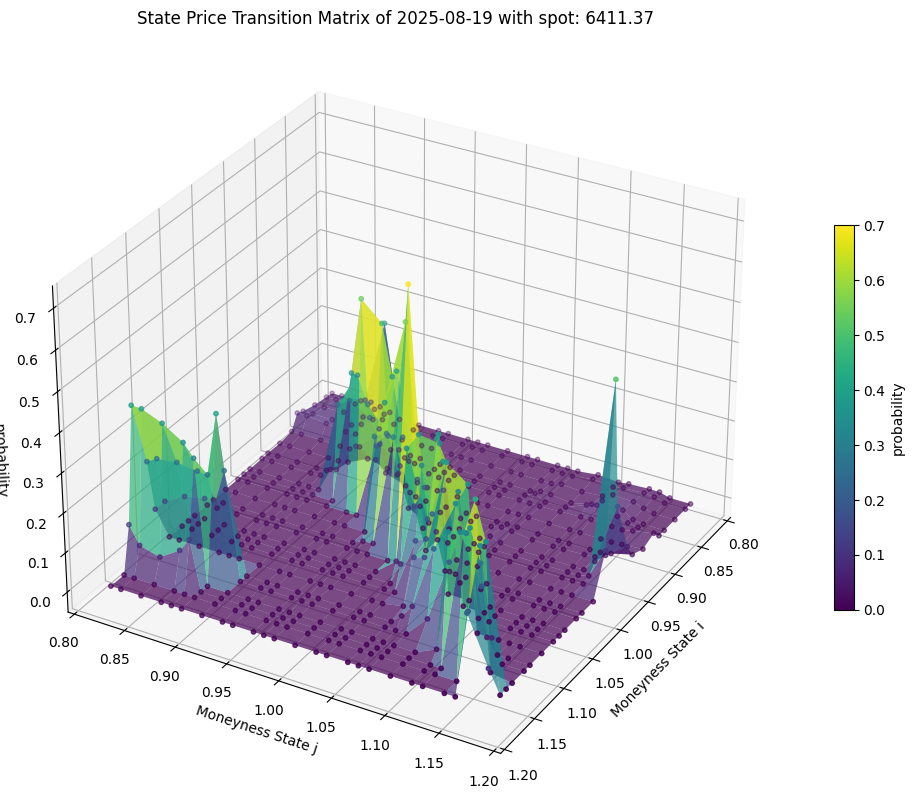

In [419]:
NaturalMatrix, phi, delta= natural_probability(TransState, path=PATH, date=DATE)

plot_3d_scatter(NaturalMatrix, size=(14, 10), elev=30, azim=30,
                path=PATH, date=DATE, spot=SPOT, title='State Price Transition Matrix', x_label='Moneyness State i',
                y_label='Moneyness State j', z_label='probability', file_name='NaturalProbabilitySurface')

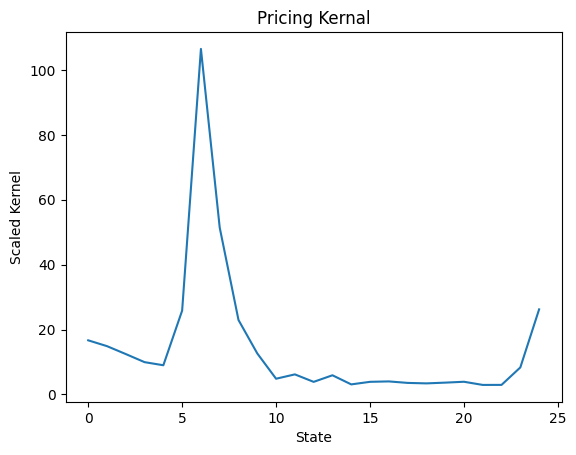

In [407]:
 # plot phi and sav
plt.figure()
plt.plot(phi)
plt.title("Pricing Kernal")
plt.xlabel("State")
plt.ylabel("Scaled Kernel")
plt.savefig(PATH + f'/{DATE}PricingKernal.png')
plt.show()
plt.close()